### **Due Date**
2/29/2024 at 11:59PM EST

# **Introduction**

Welcome to Assignment 2 of 4756. In this assignment, you will train an agent using demonstrations from an expert. Concretely, you will:
* Implement behavior cloning (BC) and dataset aggregation (DAgger) methods
* **Extra Credit:** Get imitation learning working under causal confounds

You will use the Hopper agent for this assignment, which is part of Gym’s Mujoco Environments. Refer to the Gym website for more details about the [Hopper environment](https://gymnasium.farama.org/environments/mujoco/hopper/).


Please read through the following paragraphs carefully, as they will apply to this and all future assignments.

**Getting Started:** This assignment should be completed in [Google Colab](https://colab.research.google.com/). In order to access the python files bc.py and dagger.py which you will be editing, it is necessary to first upload the folder A2_FILES to your google drive and then mount your Google Drive in Colab. To do so, carefully follow the directions below in the section **Mounting Google Drive to Colab**, or reference the instructions [here](https://saturncloud.io/blog/how-to-import-python-files-in-google-colaboratory/). Additionally, make sure to switch your runtime type to GPU; this will help speed up the training process.

**Evaluation:**
Your code will be tested for correctness and, for certain assignments, speed. For this particular assignment, performance results will not be harshly graded (although we provide approximate expected reward numbers as lower bounds, you are not expected to replicate them exactly); however, it will be important to make an effort to justify your approach which led to the obtained results. Please remember that all assignments should be completed individually.

**Academic Integrity:** We will be checking your code against other submissions in the class for logical redundancy. If you copy someone else’s code and submit it with minor changes, we will know. These cheat detectors are quite hard to fool, so please don’t try. We trust you all to submit your own work only; please don’t let us down. If you do, we will pursue the strongest consequences available to us.

**Getting Help:** The [Resources](https://www.cs.cornell.edu/courses/cs4756/2024sp/#resources) section on the course website is your friend! If you ever feel stuck in these projects, please feel free to avail yourself to office hours and Edstem! If you are unable to make any of the office hours listed, please let TAs know and we will be happy to assist. If you need a refresher for PyTorch, please see this [60 minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)! For Numpy, please see the quickstart [here](https://numpy.org/doc/stable/user/quickstart.html) and full API [here](https://numpy.org/doc/stable/reference/).


### **Imports**

In [2]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf
!pip install gym

!pip install free-mujoco-py
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install imageio==2.4.1
!pip install -U colabgymrender
!pip install mujoco

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.9).
The following additional packages will be installed:
  libegl-dev libgl-dev libgles-dev libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev
  libglvnd-dev libglx-dev libopengl-dev libosmesa6
The following NEW packages will be installed:
  libegl-dev libgl-dev libgl1-mesa-dev libgl1-mesa-glx libgles-dev libgles1 libglew-dev
  libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev libopengl-dev libosmesa6
  libosmesa6-dev
0 upgraded, 15 newly installed, 0 to remove and 35 not upgraded.
Need to get 4,020 kB of archives.
After this operation, 19.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgl-dev amd64 1.4.0-1 [101 kB]
Get:3 http://archive.ubuntu.com/ubuntu 

In [3]:
import gym
import torch.nn as nn
import torch
import numpy as np
import random
import tqdm
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import optimizer
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [4]:
# Setting the seed to ensure reproducability
def reseed(seed):
  torch.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)

reseed(42)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **Mounting Google Drive in Colab**

Before you complete this step, make sure that you have uploaded the folder A2_FILES to your Google Drive. Once you have done that, you need to mount your Google Drive in Colab. In order to do so, run the cell below. Running this cell will prompt you to authorize Colab to access your drive. Follow the instructions to complete the authorization process.

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Next, locate A2_FILES on the left panel in Colab. To do so, navigate to Files/drive/MyDrive. At this point, you should see the contents of your Google Drive. Locate A2_FILES in your drive, and if necessary, modify the cell below such that you are correctly indicating the file path to A2_FILES. You will append the path to A2_FILES to the system path. If you have completed this step correctly, you should be able to successfully import the BC and DAgger modules into this notebook.

In [6]:
import sys
sys.path.append('/content/drive/MyDrive/A2/A2_FILES')

### **Setting Up the Environment**

In [7]:
def make_env(env_id, seed=42, p_tremble=0.0):
    env = gym.make(env_id, render_mode=None) # Change render_mode = rbg_array to render
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env
env = make_env('Hopper-v3')

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment Hopper-v3 is out of date. You should consider upgrading to version `v4`.
  logger.warn(


Compiling /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx


INFO:root:running build_ext
INFO:root:building 'mujoco_py.cymj' extension
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local/lib
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-31

### **Visualizing the Hopper environment with random actions**

We have provided functions to visualize the environment and compute rewards on the Hopper environment with random actions. Looking through this code will help you get familiarized with the environment, and set you up for the next parts in this assignment.

Total Reward using Random Actions =  36.194235803705816


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


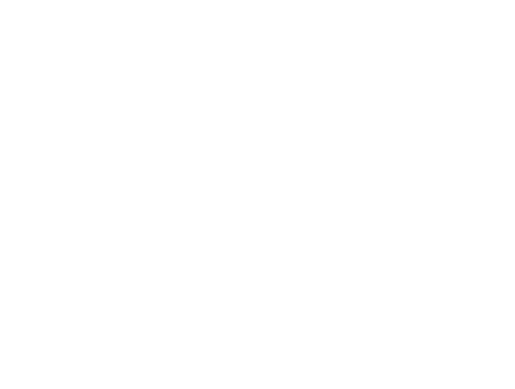

In [8]:
plt.axis('off')
done = False
visualize = False # set to false in order to disable rendering code
obs = env.reset()
total_random_reward = 0
i = 0
while not done:
    i += 1
    if i%5==0 and visualize:
        ipythondisplay.clear_output(wait=True)
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    total_random_reward += reward
    if done:
        break
print("Total Reward using Random Actions = ", total_random_reward)

**Approximate expected reward for total reward using random actions: 27**

In [9]:
# Download Hopper expert policy
!wget https://github.com/portal-cornell/cs4756-robot-learning-sp24/raw/main/assignments/A2/experts/hopper.pt

--2024-03-01 18:48:44--  https://github.com/portal-cornell/cs4756-robot-learning-sp24/raw/main/assignments/A2/experts/hopper.pt
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/portal-cornell/cs4756-robot-learning-sp24/main/assignments/A2/experts/hopper.pt [following]
--2024-03-01 18:48:44--  https://raw.githubusercontent.com/portal-cornell/cs4756-robot-learning-sp24/main/assignments/A2/experts/hopper.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 284515 (278K) [application/octet-stream]
Saving to: ‘hopper.pt’

hopper.pt           100%[===================>] 277.85K  --.-KB/s    in 0.02s  

### **Neural Networks in PyTorch**

We have provided some code for implementing simple neural networks (fully connected, multilayer perceptrons) in PyTorch, including the ExpertActor and Learner classes. We have also provided code for checkpointing for saving your best performing model. If you wish to learn more about how to construct and train neural networks in PyTorch, check out the tutorials on [pytorch.org](https://pytorch.org/).

### ExpertActor Class

In [10]:
LOG_STD_MAX = 2
LOG_STD_MIN = -5

class ExpertActor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale",
            torch.tensor(
                (env.action_space.high - env.action_space.low) / 2.0,
                dtype=torch.float32,
            ).reshape(1, -1),
        )
        self.register_buffer(
            "action_bias",
            torch.tensor(
                (env.action_space.high + env.action_space.low) / 2.0,
                dtype=torch.float32,
            ).reshape(1, -1),
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (
            log_std + 1
        )

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

    def get_expert_action(self, obs, random_prob=0.0):
        if np.random.random() < random_prob:
            return env.action_space.sample()
        else:
            action = self.get_action(torch.tensor([obs]).float())
            return np.array(action[0][0].detach().cpu())

ckpt_path = "hopper.pt"
expert = ExpertActor(env).to('cpu')
expert.load_state_dict(torch.load(str(ckpt_path), map_location='cpu'))

<All keys matched successfully>

### Learner Class

In [11]:
class Learner(nn.Module):
    def __init__(self, env, hidden_dim = 256, random_prob=0.0):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod(), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, np.prod(env.action_space.shape))

        self.env = env
        self.random_prob = random_prob

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = F.tanh(self.fc_out(x))
        return out

    def get_action(self, obs):
        if np.random.random() < self.random_prob:
            return self.env.action_space.sample()
        action = self.forward(torch.tensor([obs]).float().to(device))
        return np.array(action[0].detach().cpu())

### Checkpointing Functions

In [12]:
def get_checkpoint_path(algo):
    """Return the path to save the best performing model checkpoint.

    Parameters:
        algo (str)
          Indicates which algorithm will be used to train the model

    Returns:
        checkpoint_path (str)
            The path to save the best performing model checkpoint
    """
    if algo == "bc":
      return 'best_bc_checkpoint.pth'
    elif algo == "dagger":
      return 'best_dagger_checkpoint.pth'
    return 'best_model_checkpoint.pth'

def load_model_checkpoint(checkpoint_path):
    """Load a model checkpoint from disk.

    Parameters:
        checkpoint_path (str)
            The path to load the checkpoint from

    Returns:
        model (torch.nn.Module)
            The model loaded from the checkpoint
    """
    model = Learner(env)
    model.load_state_dict(torch.load(checkpoint_path))
    return model

### **Visualizing the Hopper environment with the expert policy**

We have provided a visualization for computing rewards using the expert policy on the Hopper environment.

0.417022004702574
0.00011437481734488664
0.14675589081711304
0.1862602113776709
0.39676747423066994
0.4191945144032948
0.20445224973151743
0.027387593197926163
0.41730480236712697
0.14038693859523377
0.8007445686755367
0.31342417815924284
0.8763891522960383
0.08504421136977791
0.1698304195645689
0.0983468338330501
0.9578895301505019
0.6918771139504734
0.6865009276815837
0.018288277344191806
0.9888610889064947
0.2804439920644052
0.10322600657764203
0.9085955030930956
0.28777533858634874
0.019366957870297075
0.21162811600005904
0.4915731592803383
0.5741176054920131
0.5893055369032842
0.10233442882782584
0.6944001577277451
0.04995345894608716
0.6637946452197888
0.9445947559908133
0.9034019152878835
0.13927634725075855
0.3976768369855336
0.9275085803960339
0.7508121031361555
0.8833060912058098
0.7509424340273372
0.2699278917650261
0.4280911898712949
0.6634414978184481
0.11474597295337519
0.4499121334799405
0.40813680276128117
0.9033795205622538
0.00287032703115897
0.32664490177209615
0.885

<ipython-input-10-33d12b820a6d>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  action = self.get_action(torch.tensor([obs]).float())


0.06600017272206249
0.7538761884612464
0.7115247586284718
0.01988013383979559
0.028306488020794607
0.860027948682888
0.5528219786857659
0.12417331511991114
0.5857592714582879
0.56103021925571
0.8006326726806163
0.8071051956187791
0.8635418545594287
0.5562402339904189
0.05991768951221166
0.044551878544761725
0.2257093386078547
0.5597169820541424
0.07197427968948678
0.5681004619199421
0.2523257445703234
0.1954294811093188
0.9700199890883123
0.23984775914758616
0.6199557183813798
0.15679139464608427
0.07002214371922233
0.6063294616533303
0.31736240932216075
0.5797452192457969
0.5509482191178968
0.6692328934531846
0.06633483442844157
0.6297175070215645
0.7527555537388139
0.26031509857854096
0.19343428262332774
0.5246703091237337
0.263296770487111
0.7350659632886695
0.907815852503524
0.013951572975597015
0.6167783570016576
0.9501761192470797
0.9156063497662745
0.39000771414124624
0.6043104829199732
0.9261814267064536
0.3948756129235549
0.17395566668046436
0.13507915804673132
0.0215248052741

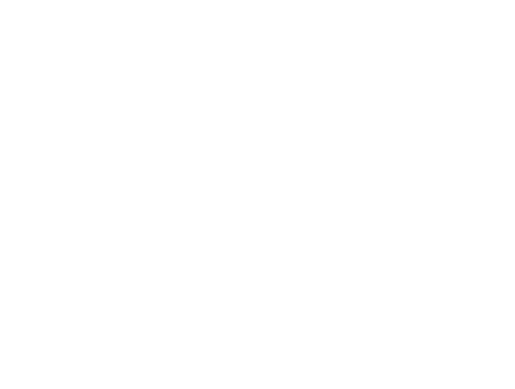

In [13]:
plt.axis('off')
done = False
visualize = False # set to false in order to disable rendering code
reseed(1)
obs = env.reset(seed=1)
total_expert_reward = 0
i = 0
while not done:
    i += 1
    if i%20==0 and visualize:
        ipythondisplay.clear_output(wait=True)
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
    with torch.no_grad():
        action = expert.get_expert_action(obs)
    obs, reward, done, info = env.step(action)
    total_expert_reward += reward
    if done:
        break
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Random Actions = {total_random_reward}\n")

**Approximate expected reward for total reward using expert policy: 2238**

### **Data collection**

We have provided some code to collect 50 demonstrations using the expert policy. To collect a different number of  trajectories, change the value of the NUM_TRAJS variable.

### Collecting and processing offline data

In [13]:
### Collecting trajectories (i.e. demonstrations) using the expert policy
NUM_TRAJS = 50
observations, actions = [], []
reseed(1)
for traj_num in tqdm(range(NUM_TRAJS)):
    print("Collecting trajectory ", traj_num+1)
    done = False
    obs = env.reset(seed = 1)
    while not done:
        with torch.no_grad():
            action = expert.get_expert_action(obs)
            observations.append(obs)
            actions.append(action)
            obs, reward, done, info = env.step(action)
        if done:
            break

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:19,  1.62s/it]

  4%|▍         | 2/50 [00:02<01:01,  1.29s/it]

  6%|▌         | 3/50 [00:03<00:50,  1.08s/it]

  8%|▊         | 4/50 [00:04<00:51,  1.12s/it]

 10%|█         | 5/50 [00:05<00:50,  1.12s/it]

 12%|█▏        | 6/50 [00:07<00:53,  1.22s/it]

 14%|█▍        | 7/50 [00:08<00:56,  1.31s/it]

 16%|█▌        | 8/50 [00:12<01:21,  1.93s/it]

 18%|█▊        | 9/50 [00:13<01:13,  1.78s/it]

 20%|██        | 10/50 [00:15<01:14,  1.85s/it]

 22%|██▏       | 11/50 [00:16<01:08,  1.75s/it]

 24%|██▍       | 12/50 [00:17<00:56,  1.48s/it]

 26%|██▌       | 13/50 [00:19<00:53,  1.43s/it]

 28%|██▊       | 14/50 [00:19<00:44,  1.24s/it]

 30%|███       | 15/50 [00:20<00:37,  1.06s/it]

 32%|███▏      | 16/50 [00:21<00:32,  1.06it/s]

 34%|███▍      | 17/50 [00:22<00:29,  1.11it/s]

 36%|███▌      | 18/50 [00:23<00:30,  1.05it/s]

 38%|███▊      | 19/50 [00:24<00:29,  1.06it/s]

 40%|████      | 20/50 [00:24<00:27,  1.09it/s]

 42%|████▏     | 21/50 [00:25<00:26,  1.11it/s]

 44%|████▍     | 22/50 [00:26<00:25,  1.10it/s]

 46%|████▌     | 23/50 [00:27<00:22,  1.19it/s]

 48%|████▊     | 24/50 [00:28<00:20,  1.25it/s]

 50%|█████     | 25/50 [00:28<00:19,  1.28it/s]

 52%|█████▏    | 26/50 [00:29<00:16,  1.42it/s]

 54%|█████▍    | 27/50 [00:30<00:17,  1.33it/s]

 56%|█████▌    | 28/50 [00:30<00:16,  1.36it/s]

 58%|█████▊    | 29/50 [00:31<00:16,  1.24it/s]

 60%|██████    | 30/50 [00:32<00:14,  1.33it/s]

 62%|██████▏   | 31/50 [00:33<00:13,  1.43it/s]

 64%|██████▍   | 32/50 [00:34<00:13,  1.31it/s]

 66%|██████▌   | 33/50 [00:34<00:12,  1.36it/s]

 68%|██████▊   | 34/50 [00:35<00:12,  1.31it/s]

 70%|███████   | 35/50 [00:36<00:10,  1.38it/s]

 72%|███████▏  | 36/50 [00:36<00:09,  1.45it/s]

 74%|███████▍  | 37/50 [00:37<00:09,  1.31it/s]

 76%|███████▌  | 38/50 [00:38<00:08,  1.34it/s]

 78%|███████▊  | 39/50 [00:39<00:08,  1.37it/s]

 80%|████████  | 40/50 [00:39<00:07,  1.28it/s]

 82%|████████▏ | 41/50 [00:40<00:07,  1.20it/s]

 84%|████████▍ | 42/50 [00:41<00:06,  1.29it/s]

 86%|████████▌ | 43/50 [00:42<00:04,  1.41it/s]

 88%|████████▊ | 44/50 [00:43<00:04,  1.31it/s]

 90%|█████████ | 45/50 [00:43<00:03,  1.38it/s]

 92%|█████████▏| 46/50 [00:44<00:02,  1.46it/s]

 94%|█████████▍| 47/50 [00:45<00:02,  1.39it/s]

 96%|█████████▌| 48/50 [00:45<00:01,  1.48it/s]

 98%|█████████▊| 49/50 [00:46<00:00,  1.35it/s]

100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


# **Q1: Behavior Cloning (BC) with Shaky Hands**

To begin, fill in the implementation for the training loop function in **bc.py** found in **A2_FILES**. We provide the loss function and optimizer already, just iterate through your dataloader and return the updated policy!

Once you finish the training loop implementation, it is now time to build up your agents! **Behavior cloning (BC)** is the simplest imitation learning algorithm, where we perform supervised learning on the given (offline) expert dataset. We either do this via log-likelihood maximization (cross-entropy minimization) in the discrete action case, or mean-squared error minimization (can also do MLE) in the continuous control setting.

If implemented correctly, training your BC model should take roughly 15 minutes.

### Train Behavior Cloning (BC) Model

In [14]:
%load_ext autoreload
%autoreload 2

In [ ]:
import bc

bc_learner = Learner(env)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bc_learner.to(device)
checkpoint_path = get_checkpoint_path("bc")
reseed(2)
res = bc.train(bc_learner, observations, actions, checkpoint_path, num_epochs = 1500)

Training:   9%|▊         | 129/1500 [01:07<11:00,  2.08it/s]

### Visualize the learner policy and compare rewards with expert policy

In [ ]:
done = False
visualize = False # set to false in order to disable rendering code
reseed(2)
obs = env.reset(seed = 2)
total_learner_reward = 0
i= 0
while not done:
    if i%20==0 and visualize:
        ipythondisplay.clear_output(wait=True)
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
    with torch.no_grad():
        action = bc_learner.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_learner_reward += reward
    if done:
        break
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Policy = {total_learner_reward}\n")

**Approximate expected reward for total reward using learned policy: 1000**

Most likely, the performance of your BC agent will be very close to the expert.  However, what happens if your learner has SHAKY HANDS, i.e it executes random actions every few timesteps?

Concretely, set the probability of a random action by the learner to be just 5% (code already provided). You will probably see that the performance of the learner tanks!

### Add 1% random actions to learner and check rewards

In [ ]:
bc_learner.random_prob = 0.05
checkpoint_path = "random_acts"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bc_learner.to(device)
reseed(2)
bc.train(bc_learner, observations, actions, checkpoint_path, num_epochs = 1500)

### Visualize learner policy with random actions and compare rewards with expert policy

In [ ]:
done = False
visualize = False # set to false in order to disable rendering code
reseed(2)
obs = env.reset(seed=2)
total_learner_reward = 0
i= 0
while not done:
    if i%5==0 and visualize:
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
        ipythondisplay.clear_output(wait=True)
    with torch.no_grad():
        action = bc_learner.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_learner_reward += reward
    if done:
        break
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Policy (Random Actions)= {total_learner_reward}\n")

**Approximate expected reward for total reward using learned policy with 1% random actions: 111**

# **Q2: DAgger**

**Dataset aggregation (DAgger)** is a fundamentally interactive algorithm, where we can query the expert any time we want to get information about how to proceed. This allows for significantly more freedom for the learner, as it can ask the expert anywhere and not be limited by the dataset that it is given to learn from.

**Can we overcome shaky hands with DAgger?** Fundamentally, this algorithm allows the learner to recover from bad states and should lead to much better performance than simply behavior cloning a fixed set of expert demonstrations. For this portion of the assignment, you will interact with the environment using the learner policy with random actions. You will do so in **dagger.py** found in **A2_FILES**.

Remember to initialize the DAgger policy with the already learned BC policy and your dataset with the already collected expert demonstrations for BC.



### Initialize DAgger with BC

In [ ]:
dagger_learner = Learner(env)
dagger_learner.random_prob = 0.05
dagger_learner.load_state_dict(torch.load(get_checkpoint_path("bc")))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dagger_learner.to(device)

### Interact with the environment using the learner policy with random actions

In [ ]:
import dagger

observations, actions = [], [] # this has already been initialized earlier, why set to empty
checkpoint_path = get_checkpoint_path("dagger")
seed = 2
reseed(seed)
dagger.interact(env, dagger_learner, expert, observations, actions, checkpoint_path, seed, num_epochs = 500)

In [ ]:
dagger_learner.load_state_dict(torch.load(get_checkpoint_path("dagger")))
dagger_learner_last_interaction = Learner(env)
dagger_learner_last_interaction.load_state_dict(torch.load("dagger_last_epoch"))
done = False
visualize = False # set to false in order to disable rendering code
reseed(2)
obs = env.reset(seed=2)
total_best_learner_reward = 0
total_last_interaction_reward = 0
i= 0
while not done:
    if i%5==0 and visualize:
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
        ipythondisplay.clear_output(wait=True)
    with torch.no_grad():
        action = dagger_learner.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_best_learner_reward += reward
    if done:
        break
while not done:
    if i%5==0 and visualize:
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
        ipythondisplay.clear_output(wait=True)
    with torch.no_grad():
        action = dagger_learner_last_interaction.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_last_interaction_reward += reward
    if done:
        break
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Best Policy (Dagger)= {total_learner_reward}\nTotal Reward using Learned Last Policy (Dagger)= {total_last_interaction_reward}")

In [ ]:
done = False
visualize = False # set to false in order to disable rendering code
reseed(3)
obs = env.reset(seed=3)
total_best_learner_reward = 0
total_last_interaction_reward = 0
i= 0
while not done:
    if i%5==0 and visualize:
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
        ipythondisplay.clear_output(wait=True)
    with torch.no_grad():
        action = dagger_learner.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_best_learner_reward += reward
    if done:
        break
while not done:
    if i%5==0 and visualize:
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
        ipythondisplay.clear_output(wait=True)
    with torch.no_grad():
        action = dagger_learner_last_interaction.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_last_interaction_reward += reward
    if done:
        break
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Best Policy (Dagger)= {total_learner_reward}\nTotal Reward using Learned Last Policy (Dagger)= {total_last_interaction_reward}")

In [ ]:
done = False
visualize = False # set to false in order to disable rendering code
reseed(4)
obs = env.reset(seed=4)
total_best_learner_reward = 0
total_last_interaction_reward = 0
i= 0
while not done:
    if i%5==0 and visualize:
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
        ipythondisplay.clear_output(wait=True)
    with torch.no_grad():
        action = dagger_learner.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_best_learner_reward += reward
    if done:
        break
while not done:
    if i%5==0 and visualize:
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
        ipythondisplay.clear_output(wait=True)
    with torch.no_grad():
        action = dagger_learner_last_interaction.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_last_interaction_reward += reward
    if done:
        break
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Best Policy (Dagger)= {total_learner_reward}\nTotal Reward using Learned Last Policy (Dagger)= {total_last_interaction_reward}")

:**Approximate expected reward for 50 interaction with the environment: 590**

# **Extra Credit: Causal Confounds**

Congratulations, you made it! You have implemented your first few (“deep” :') ) imitation learning algorithms in PyTorch.

With that in mind, let’s dig a little deeper. A common problem in the real world is hidden information. What if parts of the robot's state are hidden from the learner? How well does imitation learning do when the expert has full state knowledge, but the learner does not?

You will need to:
* Create a “partially observable” Hopper environment where the last observation index (refer to Gym documentation) is hidden from the learner (note that it’s still available to the expert!)
* Obtain rewards for both BC and DAgger. How well do BC and DAgger work for the partially observable Hopper environment? Explain the performance of each.

**Note:** For this part, BC and DAgger should just work if you did things right.


In [ ]:
class Learner_hidden(nn.Module):
    def __init__(self, env, hidden_dim = 256, random_prob=0.0):
        super().__init__()
        self.fc1 = nn.Linear(10, hidden_dim) # 10 because one index from observation is hidden
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, np.prod(env.action_space.shape))

        self.env = env
        self.random_prob = random_prob

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = F.tanh(self.fc_out(x))
        return out

    def get_action(self, obs):
        if np.random.random() < self.random_prob:
            return self.env.action_space.sample()
        # print(torch.tensor([obs]).device())
        action = self.forward(torch.tensor([obs]).float().to(device))
        return np.array(action[0].detach().cpu())

In [ ]:
### Collecting trajectories (i.e. demonstrations) using the expert policy
NUM_TRAJS = 50
observations, actions = [], []
reseed(1)
for traj_num in tqdm(range(NUM_TRAJS)):
    print("Collecting trajectory ", traj_num+1)
    done = False
    obs = env.reset(seed = 1)
    while not done:
        with torch.no_grad():
            action = expert.get_expert_action(obs)
            observations.append(obs[:-1])
            actions.append(action)
            obs, reward, done, info = env.step(action)
        if done:
            break

In [ ]:
print(len(observations[0]))

In [ ]:
bc_learner_hidden = Learner_hidden(env)
bc_learner_hidden.random_prob = 0.05
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bc_learner_hidden.to(device)

reseed(2)
bc.train(bc_learner_hidden, observations, actions, "bc_hidden", num_epochs = 1500)

In [ ]:
done = False
visualize = False # set to false in order to disable rendering code
reseed(2)
obs = env.reset(seed = 2)
total_learner_reward = 0
i= 0
while not done:
    if i%20==0 and visualize:
        ipythondisplay.clear_output(wait=True)
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
    with torch.no_grad():
        action = bc_learner_hidden.get_action(obs[:-1])
    obs, reward, done, info = env.step(action)
    total_learner_reward += reward
    if done:
        break
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Policy = {total_learner_reward}\n")

In [ ]:
import bc
import torch

def interact_hidden(env, learner, expert, observations, actions, checkpoint_path, seed, num_epochs=100):
  """Interact with the environment and update the learner policy using DAgger.

    This function interacts with the given Gym environment and aggregates to
    the BC dataset by querying the expert.

    Parameters:
        env (Env)
            The gym environment (in this case, the Hopper gym environment)
        learner (Learner)
            A Learner object (policy)
        expert (ExpertActor)
            An ExpertActor object (expert policy)
        observations (list of numpy.ndarray)
            An initially empty list of numpy arrays
        actions (list of numpy.ndarray)
            An initially empty list of numpy arrays
        checkpoint_path (str)
            The path to save the best performing model checkpoint
        seed (int)
            The seed to use for the environment
        num_epochs (int)
            Number of epochs to run the train function for
    """
  # Interact with the environment and aggregate your BC Dataset by querying the expert
  NUM_INTERACTIONS = 50
  best_reward = float("-inf")
  best_state_dict = None
  for episode in range(NUM_INTERACTIONS):
      total_learner_reward = 0
      done = False
      obs = env.reset(seed=seed)
      while not done:
        # TODO: Implement Hopper environment interaction and dataset aggregation here
        with torch.no_grad():
            learner_action = learner.get_action(obs[:-1])
            expert_action = expert.get_expert_action(obs)
            observations.append(obs[:-1])

            # aggregate new expert action
            actions.append(expert_action)
            obs, reward, done, info = env.step(learner_action)
            total_learner_reward += reward
        if done:
          break
      print(f"After interaction {episode}, reward = {total_learner_reward}")
      if total_learner_reward > best_reward:
        best_reward = total_learner_reward
        best_state_dict = learner.state_dict()
      bc.train(learner, observations, actions, "dagger_hidden_last_epoch", num_epochs)

  torch.save(best_state_dict, checkpoint_path)
  learner.load_state_dict(best_state_dict)

  return learner

In [ ]:
dagger_learner_hidden = Learner_hidden(env)
dagger_learner_hidden.random_prob = 0.05
dagger_learner_hidden.load_state_dict(torch.load("bc_hidden"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dagger_learner_hidden.to(device)

observations, actions = [], []
seed = 2
reseed(seed)
interact_hidden(env, dagger_learner_hidden, expert, observations, actions, "dagger_hidden", seed, num_epochs = 500)

In [ ]:
done = False
visualize = False # set to false in order to disable rendering code
reseed(2)
obs = env.reset(seed = 2)
total_learner_reward = 0
i= 0
while not done:
    if i%20==0 and visualize:
        ipythondisplay.clear_output(wait=True)
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
    with torch.no_grad():
        action = dagger_learner_hidden.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_learner_reward += reward
    if done:
        break
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Policy = {total_learner_reward}\n")


1.   How do they do in comparison to the fully observable environments? Why is this the case?
2.   How do they do in comparison to one another? Why is this the case?




